#GMDL 222 -  PS 3 - Autoencoders
## Resources
- Some figures are taken from [here](https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798).
- training code is modified from [here](https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py).

In [ ]:
import os

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt 
from tqdm import tqdm

# Autoencoder

![img](https://miro.medium.com/max/1400/1*MMRDQ4g3QvQNc7iJsKM9pg@2x.png)

## MNIST example

### Data - Subset of 10,000 examples
Notice the use of 

```python
train_subset_sampler = SubsetRandomSampler(train_subset_idx)
```



In [ ]:
def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

# define parameters
num_epochs = 100
batch_size = 128
learning_rate = 0.001

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

# Get data from torchvision.datasets
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

# Train on a random subset of 10k examples
N = 10000
torch.manual_seed(0)
np.random.seed(0)


# sample indicies
train_size = len(trainset)
train_idx = np.arange(train_size)
train_subset_idx = np.random.choice(train_idx, N)
train_subset_sampler = SubsetRandomSampler(train_subset_idx)

# set sampler for trainset - note: no shuffle argument when sampler is provided
trainloader = DataLoader(trainset, batch_size=batch_size, sampler=train_subset_sampler)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


### Model
The Autoencoder model. Composed of fully-connected encoder 
and decoder. Below, a **Multi-task Autoencoder (ML-AE)**. 

Q1: Why are we using a code size of 2? 

Q2: What are the advantages and disadvantages of a ML-AE compared with an AE? 

In [ ]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.code_size = 2 
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 
            self.code_size))
        self.decoder = nn.Sequential(
            nn.Linear(self.code_size, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector)
        return recon

In [ ]:
class ML_autoencoder(autoencoder):
    def __init__(self):
        # inhert from parent
        super(ML_autoencoder, self).__init__()
        self.n_classes = 10
        # Add classification head
        self.clf = nn.Sequential(
            nn.Linear(self.code_size, self.n_classes),
            nn.LogSoftmax(dim=1)
            )

    def forward(self, x):
        encoded_vector = self.encoder(x)
        recon = self.decoder(encoded_vector)
        preds = self.clf(encoded_vector)
        return recon, preds

### Training 
**Reconstruction loss:** We will compute the Mean-squared error (MSE) between the reconstructed images and the original ones.

**Classification loss:** If ML-AE is chosen, we will also compute the NLL between the class labels and the classification head predictions

In [133]:
device = 'cuda'

criterion = nn.MSELoss()
clf_criterion = nn.NLLLoss() 
#############################################
# choose whether to use Multi-task AE or not#
#############################################
ml_ae = False
if ml_ae:
  model = ML_autoencoder().to(device)
else:
  model = autoencoder().to(device)


optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=1e-5)
# a list to hold the loss across epochs
loss_train = []

for epoch in tqdm(range(num_epochs)):
    loss_epoch = 0
    for data in trainloader:
        img, labels = data
        img = img.view(img.size(0), -1)
        img = Variable(img).to(device)
        labels = labels.to(device)
        # ===================forward=====================
        if ml_ae:
          recon, preds =  model(img)
        else:
          recon = model(img)
        loss = criterion(recon, img)
        if ml_ae:
          loss += clf_criterion(preds, labels)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item()
    # divide by number of batchs
    loss_epoch = loss_epoch / len(trainloader)
    loss_train.append(loss_epoch)
    
model.eval()

100%|██████████| 100/100 [02:53<00:00,  1.74s/it]


autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

Text(0.5, 1.0, 'AE training loss')

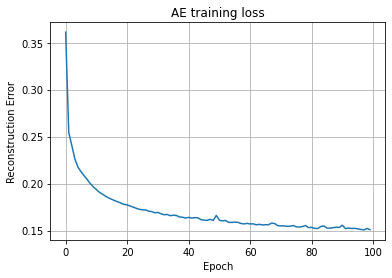

In [134]:
plt.plot(loss_train)
plt.xlabel("Epoch")
plt.ylabel("Reconstruction Error")
plt.grid()
plt.title("AE training loss")

### Inspect results

In [135]:
def get_imgs_and_recon(model, dataloader):
  # get one batch of imgs and their reconstruction
  for data in dataloader:
    imgs, _ = data
    imgs = imgs.view(imgs.size(0), -1)
    imgs = Variable(imgs).to(device)
    imgs_recon = model.decoder(model.encoder(imgs))
    imgs, imgs_recon = imgs.view(-1,28,28), imgs_recon.view(-1,28,28)
    # return after 1 epoch
    return imgs.detach().cpu().numpy(), imgs_recon.detach().cpu().numpy()

In [136]:
imgs, imgs_recon = get_imgs_and_recon(model, trainloader)

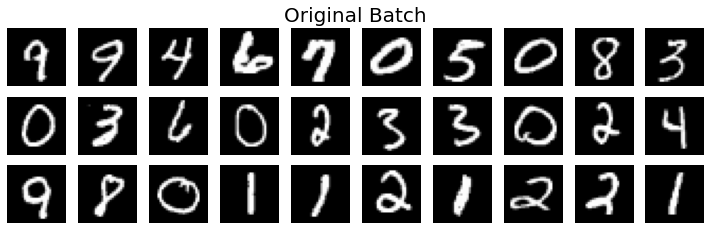

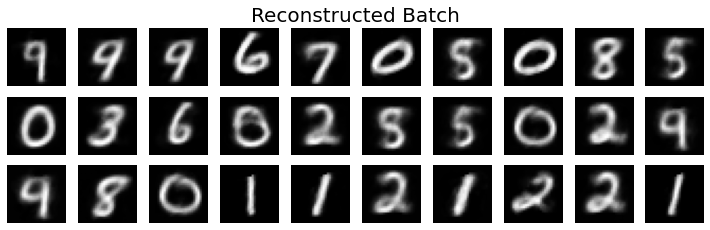

In [137]:
figure1 = plt.figure(figsize=(10,3))
num_of_images = 30
for index in range(1, num_of_images + 1):
    plt.subplot(3, 10, index)
    plt.axis('off')
    plt.imshow(imgs[index].squeeze(), cmap='gray')
plt.tight_layout()
plt.suptitle("Original Batch", y=1.05, fontsize=20)

figure2 = plt.figure(figsize=(10,3))
num_of_images = 30
for index in range(1, num_of_images + 1):
    plt.subplot(3, 10, index)
    plt.axis('off')
    plt.imshow(imgs_recon[index].squeeze(), cmap='gray')
plt.suptitle("Reconstructed Batch", y=1.05, fontsize=20)
plt.tight_layout()
plt.show()

## Visualize the encoded vectors
Let's visuzalise the encoding of the test data. 

Where:

\begin{equation}
x\in R^{28x28}\\
encoder(x;\theta)=h; 
h\in R^{2}
\end{equation}


In [138]:
model.eval()
# we will create a list which will hold a concatination of all batches
encoded_data = []
labels_all = []
for data in testloader:
    img, labels = data
    img = img.view(img.size(0), -1)
    img = Variable(img).to(device)
    # ===================forward=====================
    # note how we call the encoder
    x_code = model.encoder(img)
    encoded_data.append(x_code.detach().cpu().numpy())
    labels_all.append(labels.cpu().numpy())


In [139]:
# list of np.array to one large one
X_coded = np.concatenate(encoded_data, axis=0)
y_all = np.concatenate(labels_all, axis=0)
X_coded.shape, y_all.shape


((10000, 2), (10000,))

In [140]:
# nice visualization package
import seaborn as sns

Text(0.5, 1.0, 'MNIST test set econded vector (true labels)')

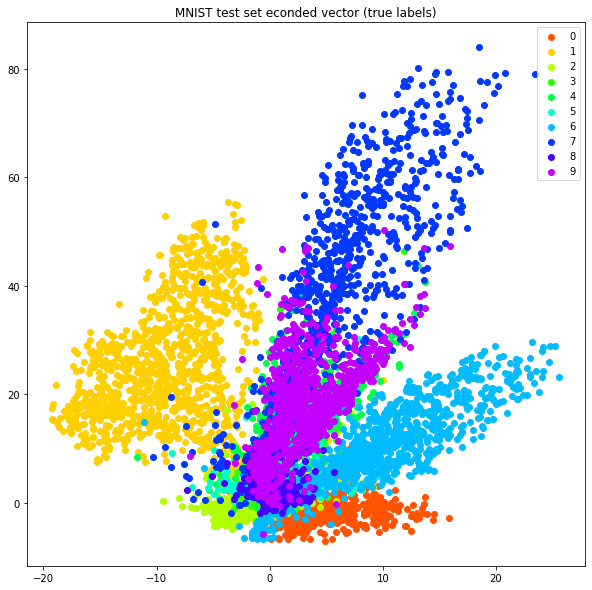

In [141]:
classes = np.unique(y_all)
clrs = sns.color_palette('gist_rainbow', n_colors=10)  # a list of RGB tuples
plt.figure(figsize=(10,10))
for k in classes:
  Xk = X_coded[y_all==k]
  yk = y_all[y_all==k]
  color = clrs[k]
  plt.scatter(Xk[:,0], Xk[:,1], color=color, label=k)
plt.legend()
plt.title("MNIST test set econded vector (true labels)")

# Clustering





## K-Means
We will use scikit-learn implementation of the [k-means algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html):



```python
class sklearn.cluster.KMeans(n_clusters=8, *, init='k-means++', 

 n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, 
 
 copy_x=True, algorithm='lloyd')
```



In [142]:
from sklearn.cluster import KMeans

In [143]:
# Init and fit via sklearn API
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_coded)


In [144]:
kmeans.cluster_centers_

array([[  0.33324957,   0.41975117],
       [ 16.072256  ,  18.898382  ],
       [  5.15252   ,  27.83537   ],
       [-11.463251  ,  19.853409  ],
       [ 11.869434  ,  64.74008   ],
       [ -0.15252328,   8.03266   ],
       [  7.310981  ,  46.229687  ],
       [ -5.807817  ,  38.77459   ],
       [  3.3122392 ,  17.018194  ],
       [  8.732861  ,   6.174436  ]], dtype=float32)

Text(0.5, 1.0, 'K-Means clustering of the encoded vector of MNIST test set')

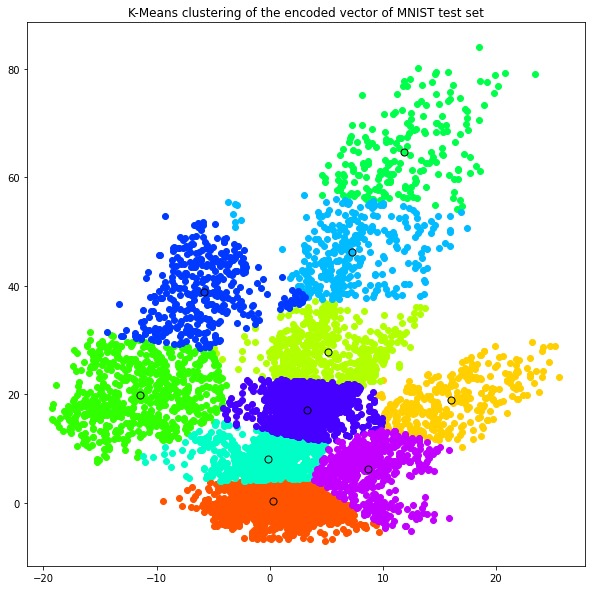

In [145]:
plt.figure(figsize=(10,10))
y_kmean = kmeans.labels_
classes_kmeans = np.unique(kmeans.labels_)
for k in classes_kmeans:
  Xk = X_coded[y_kmean==k]
  yk = y_kmean[y_kmean==k]
  color = clrs[k]
  plt.scatter(Xk[:,0], Xk[:,1], color=color, label=k)
  # plot the cluster center
  Xk_mean = kmeans.cluster_centers_[k]
  plt.scatter(Xk_mean[0], Xk_mean[1], color=color, s=50, edgecolors='black')

# plt.legend()
plt.title("K-Means clustering of the encoded vector of MNIST test set")

## Gaussian Mixture Model (GMM)


```python
class sklearn.mixture.GaussianMixture(n_components=1, *, covariance_type='full',

 tol=0.001, reg_covar=1e-06, max_iter=100, n_init=1, 
 
 init_params='kmeans', weights_init=None, means_init=None, 
 
 precisions_init=None, random_state=None, warm_start=False,
```

Convariance types:

- ‘full’: each component has its own general covariance matrix.

- ‘tied’: all components share the same general covariance matrix.

- ‘diag’: each component has its own diagonal covariance matrix.

- ‘spherical’: each component has its own single variance.

In [146]:
from sklearn.mixture import GaussianMixture


In [147]:
# fit
gmm = GaussianMixture(n_components=10, random_state=0).fit(X_coded)

Text(0.5, 1.0, 'GMM clustering of the encoded vector of MNIST test set')

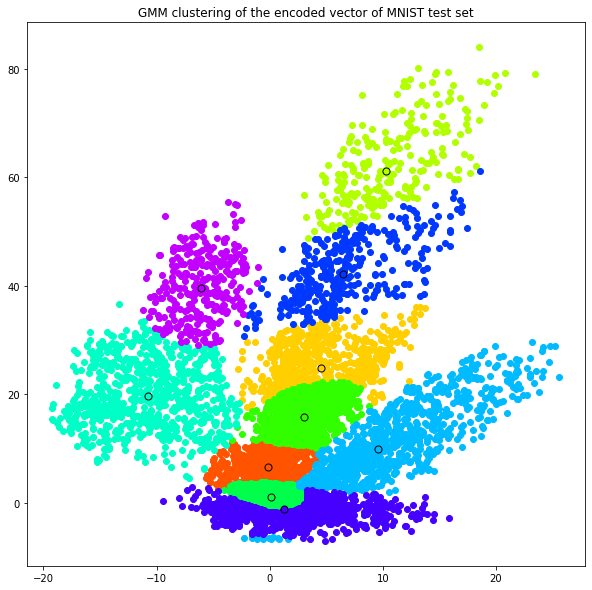

In [148]:
plt.figure(figsize=(10,10))
y_gmm = gmm.predict(X_coded)
classes_kmeans = np.unique(y_gmm)
for k in classes_kmeans:
  Xk = X_coded[y_gmm==k]
  yk = y_gmm[y_gmm==k]
  color = clrs[k]
  plt.scatter(Xk[:,0], Xk[:,1], color=color, label=k)
  # plot the cluster center
  Xk_mean = gmm.means_[k]
  plt.scatter(Xk_mean[0], Xk_mean[1], color=color, s=50, edgecolors='black')

# plt.legend()
plt.title("GMM clustering of the encoded vector of MNIST test set")

## Comparison of clustering methods

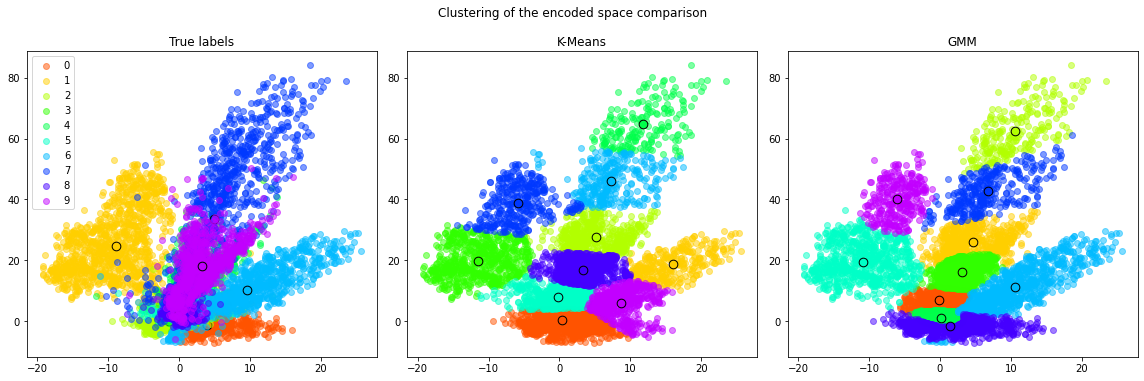

In [149]:
plt.figure(figsize=(16,5))
y_plot = [y_all, y_kmean, y_gmm]
titles = ["True labels", "K-Means", "GMM"]
# for each method
for j in range(3):
  plt.subplot(1,3,j+1)
  ys = y_plot[j]
  for k in classes:
    Xk = X_coded[ys==k]
    Xk_mean = Xk.mean(axis=0)
    yk = ys[ys==k]
    color = clrs[k]
    plt.scatter(Xk[:,0], Xk[:,1], color=color, label=k, alpha=0.5)
    plt.scatter(Xk_mean[0], Xk_mean[1], color=color, s=75, edgecolors='black')
    if j == 0:
     plt.legend()
  plt.title(titles[j])
# main title
plt.suptitle("Clustering of the encoded space comparison", y=1.05)
plt.tight_layout()

## Multi-task Autoencoder comparison

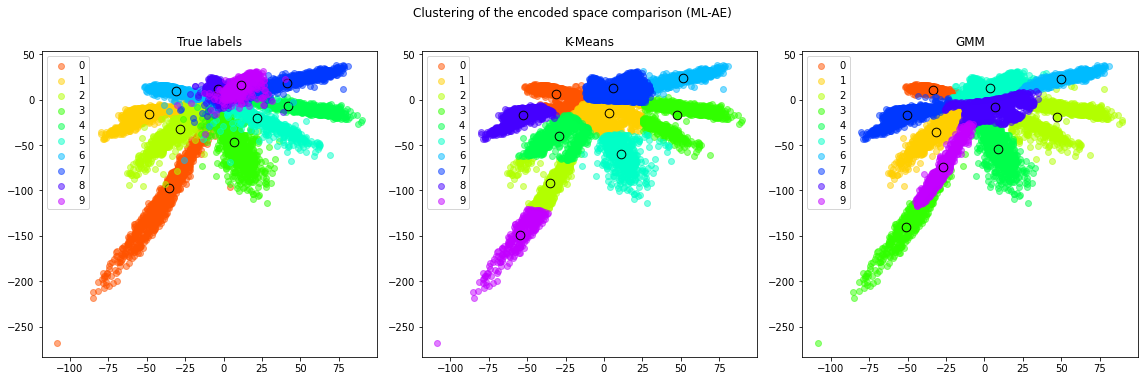

## AE (Backup)

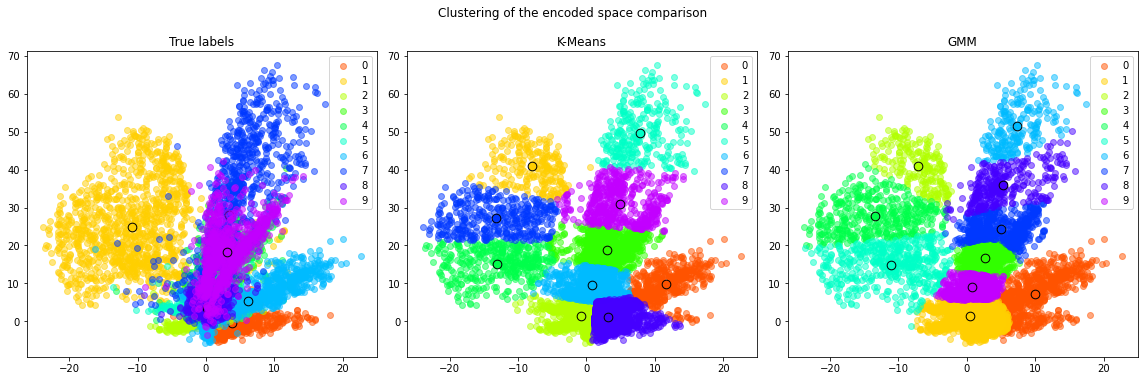